# Pulsed NMR Individual Analysis

Use this template to carry out the analysis tasks for the Noise experiment.  For reference, here are links to recommended Python resources: the [Whirlwind Tour of Python](https://jakevdp.github.io/WhirlwindTourOfPython/) and the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) both by Jake VanderPlas.

There is no need to calculate uncertainties for this analysis.  The goals here are only to see and understand general trends.  You may want to use the [LMFit](https://lmfit.github.io/lmfit-py/) package.

In [2]:
# Run this cell with Shift-Enter, and wait until the asterisk changes to a number, i.e., [*] becomes [1]
import numpy as np
import scipy.constants as const
# import uncertainties as unc
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Prior to working on this notebook:

1. Obtain the measurements of $T_1$ and $T_2$ half-life times for the series of measurements taken from Experiment 2, the effects of paramagnetic ions on the decay constants.  The data are ordered in terms of dilution "number".

2. Obtain the measurements of the delay times versus echo amplitudes from Experiment 3.  The data should be in a simple .csv spreadsheet.

### Then...
3. Import the data tables for each experiment.

### For Experiment 2:

4. Convert the "dilution number" to ion concentration in moles/liter ("molarity").  See below for details.

5. Convert the half-life times to $T_1$, $T_2$ values.

6. Plot $T_1$, and $T_2$ versus concentration on the same graph.  Select axis types (linear or log) to make the relationship look like a line.  

7. in your group document, compare your graph to the results reported by Hahn.

### For Experiment 3:

8. Convert the delay times to echo-position times.  (What is the relationship between the time of the B pulse and the echo produced by it?)

9. Plot the echo amplitudes versus echo times.

10. Fit the data set to the function given in the instructions on page 25 and 26 to obtain the constant $K$.  For $T_2$ use the result for water, and fix it so that it does not get adjusted by the fitting routine.



## Import data tables

Display them so that you know they are correct.

In [3]:
data = pd.read_csv("experiment3.csv")

## Experiment 2

### Massage the collected data

Convert the measured half-life times to $T_1$ and $T_2$ values, and convert the **Dilution number** to concentration.

Each **Dilution number** represents a dilution by a factor of 4 (i.e., one drop of solution mixed with 3 drops of pure water).  So of the original concentration is $C_0$, the first dilution is $C_0/4$ the second dilution is $C_0/4^2$, and in general the $n\,$th dilution is $C_0/4^n$.

The compound used in solution is Cupric Sulfate, 5-Hydrate (CuSO<sub>4</sub>$\cdot$5H<sub>2</sub>O) which has a formula weight of 249.68 g/mol and a slubility of 32 g/100ml of water at 20C.  Calculate the concentration in molarity (mol/liter) of the copper ions.

### Plot it

Make a plot that shows the relationship as a line (or close to it), by adjusting the axis types used to make the plot.

To see how to change the axis types, look here: [pyplot.xscale()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xscale.html#matplotlib.pyplot.xscale)

## Experiment 3: diffusion study

### Massage the collected data

Rescale the **Delay_time** data to give the echo-position time.

In [5]:
#Finding echo position and time
echo_pos = data['Delay Time(ms)'] * 2
echo_pos_ms = echo_pos * 1E-3
amp = data['Amplitude (V)']

### Plot it

Plot the echo peak voltage vs. echo-position time.

Text(0, 0.5, 'Echo Amplitude (V)')

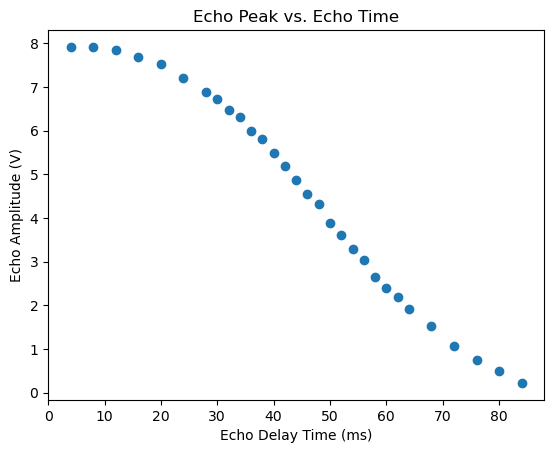

In [6]:
#Plot of echo peak vs echo position time
plt.plot(echo_pos, data['Amplitude (V)'], 'o')
plt.title('Echo Peak vs. Echo Time')
plt.xlabel('Echo Delay Time (ms)')
plt.ylabel('Echo Amplitude (V)')

###  Fit it

Use the LMFit Model class to fit the data to equation (15) in the instructions.  In this data set the number of pulses between the first FID and the echo, $n=1$.  In your fit function, set the value of $T_2$ to be a constant (not a parameter that is adjustable by the fit), and set it to the $T_2$ value obtained for pure water.

Hint: to estimate a starting value for $K$, calculate the value of the function for the time $t$ at which it is half the height it is at $t=0$.  This is like a "half-life" even though the decay is not a simple exponential.

In [14]:
## Define the fit function
def diffusion(t, Mi, T2, K, n=1):
    return Mi * np.exp(-t/T2) * np.exp(-K*t**3/n**2)
    
## pull in the Model class and set up the fit
from lmfit import Model

## Fit and plot
K_est = np.log(2) / ((47e-3)**3)
print(f'K estimate: {K_est} s^-3')
Mi_est = amp[0]
T2_est = 1.15 #s

diffusion_model = Model(diffusion)

params = diffusion_model.make_params(Mi=Mi_est, T2=1, K=K_est, n=1)
params['n'].set(value=1, vary=False)
params['T2'].set(value=T2_est, vary=False)

#Fit and fit report
result = diffusion_model.fit(amp, params, t=echo_pos_ms)
print(result.fit_report())

#Fit results
K_fit = result.params['K'].value
Mi_fit = result.params['Mi'].value
Mi_err = result.params['Mi'].stderr
K_err = result.params['K'].stderr
print(f"Fitted Mi: {Mi_fit} ± {Mi_err}")
print(f"Fitted K: {K_fit} ± {K_err}")

K estimate: 6676.239181683685 s^-3
[[Model]]
    Model(diffusion)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 30
    # variables        = 2
    chi-square         = 0.05071085
    reduced chi-square = 0.00181110
    Akaike info crit   = -187.484380
    Bayesian info crit = -184.681986
    R-squared          = 0.99971560
[[Variables]]
    Mi:  7.95916481 +/- 0.01511194 (0.19%) (init = 7.92)
    T2:  1.15 (fixed)
    K:   5272.76665 +/- 27.0851981 (0.51%) (init = 6676.239)
    n:   1 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(Mi, K) = +0.6049
Fitted Mi: 7.959164810980918 ± 0.015111943207045602
Fitted K: 5272.766649331461 ± 27.08519814949579


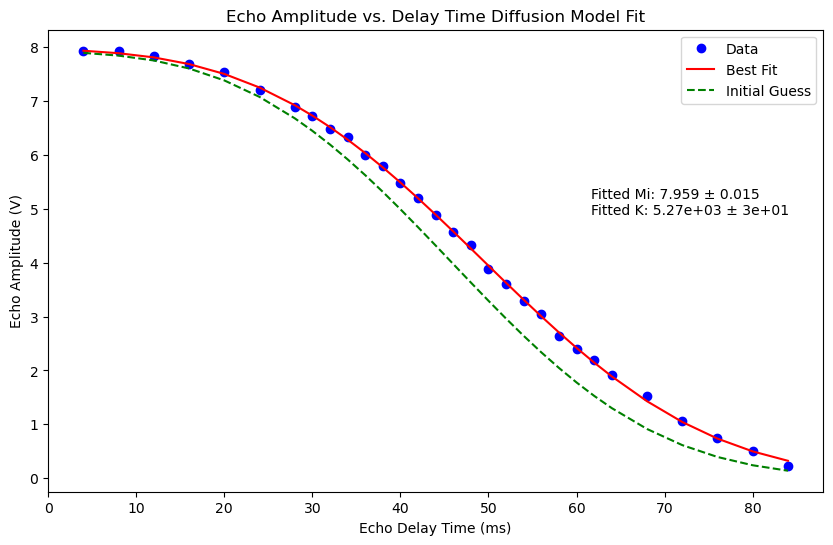

In [15]:
#Plot the fit
plt.figure(figsize=(10, 6))
plt.plot(echo_pos, amp, 'bo', label='Data')
plt.plot(echo_pos, result.best_fit, 'r-', label='Best Fit')
plt.plot(echo_pos, result.init_fit, 'g--', label='Initial Guess')
plt.title('Echo Amplitude vs. Delay Time Diffusion Model Fit')
plt.xlabel('Echo Delay Time (ms)')
plt.ylabel('Echo Amplitude (V)')
plt.text(0.7, 0.6, f"Fitted Mi: {Mi_fit:.4} ± {Mi_err:.2} \nFitted K: {K_fit:.3} ± {K_err:.1}", transform=plt.gca().transAxes)
plt.legend()
plt.show()

### Optional: Estimate the self-diffusion constant of water

According to equation (16) in the instructions, 

$$ K = \frac{\gamma^2}{12}\left(\frac{\partial B_0}{\partial z}\right)^2 D$$

and $\gamma\Delta B_0 = \Delta\omega_0$, the spread of precession frequencies that determines $T_2^*$.  From this information and the width of the simple free induction decay, you can use the result for $K$ to estimate $D$ the diffusion constant for water (at room temperature).

Try this, and compare your result against Hahn's: [Hahn, E. L., "Spin echoes", Phys. Rev., 80, 580-594 (1950)](http://courses.washington.edu/phys431/restricted/Hahn_PR80.pdf), p. 589.